# Import Data and Functions

In [ ]:
# https://www.kaggle.com/code/marcmarais/experiment-1-three-viewing-angles-only for help getting data from GolfDB dataset
# https://github.com/wmcnally/golfdb golfdb github

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.width = None
pd.set_option("max_colwidth", None)
pd.options.display.max_rows = 999
import cv2
import pickle
import gzip
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import  MinMaxScaler
from sklearn.svm import SVC
from skimage.io import imread
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")
import skimage
import os
from skimage.feature import hog
from skimage import exposure
rseed = 42

In [ ]:
import imutils
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_df(file_name):
    from scipy.io import loadmat
    import pandas as pd
    pd.options.display.width = None
    pd.set_option("max_colwidth", None)
    pd.options.display.max_rows = 999

    x = loadmat(file_name)
    l = list(x['golfDB'][0])
    d = dict()
    for idx, k in enumerate(l):
        d["{:3d}".format(idx)] = list(l[idx])
    df = pd.DataFrame(d).T
    df.columns = ["id", "youtube_id", "player", "sex", "club", "view", "slow", "events", "bbox", "split"]
    df['id'] = df['id'].apply(lambda x: x[0][0])
    df['youtube_id'] = df['youtube_id'].apply(lambda x: x[0])
    df['player'] = df['player'].apply(lambda x: x[0])
    df['sex'] = df['sex'].apply(lambda x: x[0])
    df['club'] = df['club'].apply(lambda x: x[0])
    df['view'] = df['view'].apply(lambda x: x[0])
    df['slow'] = df['slow'].apply(lambda x: x[0][0])
    df['events'] = df['events'].apply(lambda x: x[0])
    df['bbox'] = df['bbox'].apply(lambda x: x[0])
    df['split'] = df['split'].apply(lambda x: x[0][0])
    df = df.drop(columns=['split', 'youtube_id'])

    df.index = df.index.astype(int)
    df.to_csv('golfDB.csv')

    print("Number of annotations: {:3d}".format(len(df.id)))
    return df

In [ ]:
def draw_bbox(id, df):
    video = cv2.VideoCapture("/content/drive/MyDrive/GolfDB/videos/" + str(id) + ".mp4")

    iterations = 0
    event_num = 1
    events = df.events[id]
    x, y, w, h = df.bbox[id]
    x, y, w, h = int(x*160), int(y*160), int(w*160), int(h*160) #make proportional to image 160 by 160
    label = ['Address', 'Toe-up', 'Mid-Backswing', 'Top', 'Mid-Downswing', 'Impact', 'Mid-Follow-Through', 'Finish']

    while True:
        ret, frame = video.read()

        if not ret:
            break
        if iterations == events[event_num] and event_num < 9:
            cv2.imwrite("Swing_events/" + label[event_num - 1] + "/" + str(id) + ".jpg", frame)
            event_num += 1
        iterations += 1
    video.release()

### DataFrame that includes events and bbox

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

df = load_df('/content/drive/MyDrive/GolfDB/golfDB.mat')
print(df.head(10))

Number of annotations: 1400
   id            player sex    club           view  slow  \
0   0        SANDRA GAL   f  driver  down-the-line     0   
1   1        SANDRA GAL   f  driver  down-the-line     1   
2   2     CHRIS DIMARCO   m  driver  down-the-line     0   
3   3     CHRIS DIMARCO   m  driver  down-the-line     1   
4   4  BROOKE HENDERSON   f  driver  down-the-line     0   
5   5  BROOKE HENDERSON   f  driver  down-the-line     1   
6   6       NICK WATNEY   m  driver  down-the-line     0   
7   7       NICK WATNEY   m  driver  down-the-line     1   
8   8      CRISTIE KERR   f  driver        face-on     0   
9   9      CRISTIE KERR   f  driver        face-on     1   

                                                         events  \
0            [408, 455, 473, 476, 490, 495, 498, 501, 514, 545]   
1       [814, 854, 917, 931, 988, 1006, 1019, 1030, 1083, 1137]   
2            [521, 659, 678, 683, 692, 696, 698, 701, 715, 745]   
3  [1106, 1190, 1244, 1264, 1300, 1313, 132

In [ ]:
# rescale the events column
for index in df.index:
    i = 0
    events = df.events[index]
    scaled_events = []
    for event in events:
        if i == 0:
            scaled_events.append(0)
        else:
            scaled_events.append(event - events[0])
        i += 1
    df.events[index] = scaled_events

print(df.head(15))

    id            player sex    club           view  slow  \
0    0        SANDRA GAL   f  driver  down-the-line     0   
1    1        SANDRA GAL   f  driver  down-the-line     1   
2    2     CHRIS DIMARCO   m  driver  down-the-line     0   
3    3     CHRIS DIMARCO   m  driver  down-the-line     1   
4    4  BROOKE HENDERSON   f  driver  down-the-line     0   
5    5  BROOKE HENDERSON   f  driver  down-the-line     1   
6    6       NICK WATNEY   m  driver  down-the-line     0   
7    7       NICK WATNEY   m  driver  down-the-line     1   
8    8      CRISTIE KERR   f  driver        face-on     0   
9    9      CRISTIE KERR   f  driver        face-on     1   
10  10    STEVE STRICKER   m  driver        face-on     0   
11  11    STEVE STRICKER   m  driver        face-on     1   
12  12      KYLE STANLEY   m  driver  down-the-line     0   
13  13      KYLE STANLEY   m  driver          other     1   
14  14       GREG NORMAN   m  driver        face-on     0   

                       

In [ ]:
df.to_pickle("GolfDB.pkl")

In [ ]:
import shutil
if os.path.exists("./Swing_events"):
    shutil.rmtree("./Swing_events")

In [ ]:
os.makedirs('./Swing_events/Address')
os.makedirs('./Swing_events/Toe-up')
os.makedirs('./Swing_events/Mid-Backswing')
os.makedirs('./Swing_events/Top')
os.makedirs('./Swing_events/Mid-Downswing')
os.makedirs('./Swing_events/Impact')
os.makedirs('./Swing_events/Mid-Follow-Through')
os.makedirs('./Swing_events/Finish')

In [ ]:
df = pd.read_pickle("./GolfDB.pkl")
print(df.head(16))
i = 0
rows = []
while i < 1400:
    if df.view[i] in("down-the-line", "face-on", "other"): # include all views
        draw_bbox(df.id[i], df)
    if (i % 100 == 0):
        print(i)
    i += 1

    id            player sex    club           view  slow  \
0    0        SANDRA GAL   f  driver  down-the-line     0   
1    1        SANDRA GAL   f  driver  down-the-line     1   
2    2     CHRIS DIMARCO   m  driver  down-the-line     0   
3    3     CHRIS DIMARCO   m  driver  down-the-line     1   
4    4  BROOKE HENDERSON   f  driver  down-the-line     0   
5    5  BROOKE HENDERSON   f  driver  down-the-line     1   
6    6       NICK WATNEY   m  driver  down-the-line     0   
7    7       NICK WATNEY   m  driver  down-the-line     1   
8    8      CRISTIE KERR   f  driver        face-on     0   
9    9      CRISTIE KERR   f  driver        face-on     1   
10  10    STEVE STRICKER   m  driver        face-on     0   
11  11    STEVE STRICKER   m  driver        face-on     1   
12  12      KYLE STANLEY   m  driver  down-the-line     0   
13  13      KYLE STANLEY   m  driver          other     1   
14  14       GREG NORMAN   m  driver        face-on     0   
15  15       GREG NORMAN

In [ ]:
def load_image_files(container_path, dimension=(30, 30)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "Your own dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    # return in the exact same format as the built-in datasets
    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [ ]:
# dataset
swing_image_dataset = load_image_files("./Swing_events/")

# EDA

In [ ]:
swing_image_dataset.data

array([[0.47843137, 0.44705882, 0.39607843, ..., 0.47843137, 0.44705882,
        0.39607843],
       [0.53461857, 0.5459793 , 0.57073198, ..., 0.30258394, 0.33245114,
        0.23835248],
       [0.60859316, 0.58649557, 0.56281413, ..., 0.40954455, 0.3920932 ,
        0.33590909],
       ...,
       [0.47843137, 0.44705882, 0.39607843, ..., 0.47843137, 0.44705882,
        0.39607843],
       [0.47843137, 0.44705882, 0.39607843, ..., 0.47843137, 0.44705882,
        0.39607843],
       [0.64076767, 0.62261332, 0.58491322, ..., 0.39555432, 0.41454087,
        0.29107464]])

In [ ]:
type(swing_image_dataset.target)

numpy.ndarray

In [ ]:
swing_image_dataset.images.shape

(11198, 30, 30, 3)

In [ ]:
swing_image_dataset.target_names

['Mid-Backswing',
 'Mid-Follow-Through',
 'Finish',
 'Address',
 'Top',
 'Impact',
 'Mid-Downswing',
 'Toe-up']

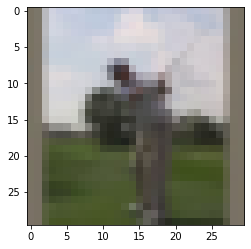

In [ ]:
image = swing_image_dataset.images[4]  # Select a specific image from the dataset
image = np.squeeze(image)  # Remove any dimensions with size 1

# Display the image
plt.imshow(image)
plt.show()

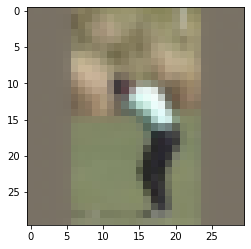

In [ ]:
image = swing_image_dataset.images[5]
image = np.squeeze(image)

plt.imshow(image)
plt.show()

# Model Building

### Import additional packages

In [ ]:
# limits the logging outside of error messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense



import datetime
import time
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Analysis Functions

In [ ]:
def plot_history(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
# shuffle the data
from sklearn.utils import shuffle

le = LabelEncoder()
labels = le.fit_transform(swing_image_dataset.target)
labels = to_categorical(labels)

X, y = shuffle(np.float32(swing_image_dataset.images), labels, random_state=42)

### Create Validation Data Set
- Training 75%
- Validation 15%
- Test 10%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.166, random_state=43)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

inputs = [30, 30, 3]

X_train = X_train.reshape(X_train.shape[0], *inputs)
X_test = X_test.reshape(X_test.shape[0], *inputs)

(8405, 30, 30, 3) (1673, 30, 30, 3) (1120, 30, 30, 3)
(8405, 8) (1673, 8) (1120, 8)


# Model 1: CNN with 2 Layers, test number of filters and dropout rates

In [ ]:
# initial filters and dropout rates on 2D

callbacks = [
     EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

initial_filters = [16, 32, 64]
dropout_rates = [0, 0.15, 0.3, 0.45]

init_filt = []
dropouts = []
train_accuracy = []
val_accuracy = []
test_accuracy = []
train_loss = []
val_loss = []
test_loss = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model = Sequential([
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Flatten(),
                Dense(units=i*2,activation=tf.nn.softmax),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])

    # compile model
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history = model.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model.evaluate(X_train, y_train)
    val_l, val_a = model.evaluate(X_valid, y_valid)
    test_l, test_a = model.evaluate(X_test, y_test)

    train_accuracy.append(train_a)
    train_loss.append(train_l)
    val_accuracy.append(val_a)
    val_loss.append(val_l)
    test_accuracy.append(test_a)
    test_loss.append(test_l)

    init_filt.append(i)
    dropouts.append(j)

Epoch 1/200
263/263 - 13s - loss: 2.0929 - accuracy: 0.1206 - val_loss: 2.1156 - val_accuracy: 0.1184 - 13s/epoch - 49ms/step
Epoch 2/200
263/263 - 2s - loss: 2.0808 - accuracy: 0.1279 - val_loss: 2.2470 - val_accuracy: 0.1273 - 2s/epoch - 6ms/step
Epoch 3/200
263/263 - 2s - loss: 2.0741 - accuracy: 0.1372 - val_loss: 2.1530 - val_accuracy: 0.1351 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 1s - loss: 2.0532 - accuracy: 0.1546 - val_loss: 2.1744 - val_accuracy: 0.1578 - 1s/epoch - 5ms/step
Epoch 5/200
263/263 - 1s - loss: 1.9906 - accuracy: 0.2071 - val_loss: 2.0165 - val_accuracy: 0.1961 - 1s/epoch - 5ms/step
Epoch 6/200
263/263 - 1s - loss: 1.8739 - accuracy: 0.2652 - val_loss: 1.9216 - val_accuracy: 0.2714 - 1s/epoch - 5ms/step
Epoch 7/200
263/263 - 1s - loss: 1.7291 - accuracy: 0.3394 - val_loss: 1.9390 - val_accuracy: 0.2624 - 1s/epoch - 5ms/step
Epoch 8/200
263/263 - 1s - loss: 1.5934 - accuracy: 0.3887 - val_loss: 1.6385 - val_accuracy: 0.3574 - 1s/epoch - 5ms/step
Epoch 9/200
2

In [ ]:
results = pd.DataFrame({
    'initial_filters': init_filt,
    'dropout': dropouts,
    'train_acc': train_accuracy,
    'val_acc': val_accuracy,
    'test_acc': test_accuracy,
    'train_loss': train_loss,
    'val_loss': val_loss,
    'test_loss': test_loss
})

print(results)

    initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0                16     0.00   0.748245  0.560669  0.553571    0.662852   
1                16     0.15   0.900178  0.719665  0.718750    0.335852   
2                16     0.30   0.811065  0.689779  0.703571    0.646669   
3                16     0.45   0.124093  0.136880  0.117857    2.122353   
4                32     0.00   0.856514  0.632397  0.644643    0.425765   
5                32     0.15   0.447829  0.413628  0.377679    1.357287   
6                32     0.30   0.545152  0.503885  0.472321    1.232051   
7                32     0.45   0.205235  0.222355  0.200000    1.987812   
8                64     0.00   0.471862  0.419605  0.408929    1.247655   
9                64     0.15   0.122665  0.127914  0.139286    2.081929   
10               64     0.30   0.124093  0.142857  0.116071    2.122219   
11               64     0.45   0.122427  0.139868  0.133036    2.171409   

    val_loss  test_loss 

# Model 2: Test more filters and dropout rates

In [ ]:
initial_filters = [4, 8, 16]
dropout_rates = [0, 0.15, 0.3, 0.45]

init_filt_2 = []
dropouts_2 = []
train_accuracy_2 = []
val_accuracy_2 = []
test_accuracy_2 = []
train_loss_2 = []
val_loss_2 = []
test_loss_2 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_2 = Sequential([
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Flatten(),
                Dense(units=i*2,activation=tf.nn.softmax),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])

    # compile model
    model_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_2 = model_2.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_2.evaluate(X_train, y_train)
    val_l, val_a = model_2.evaluate(X_valid, y_valid)
    test_l, test_a = model_2.evaluate(X_test, y_test)

    train_accuracy_2.append(train_a)
    train_loss_2.append(train_l)
    val_accuracy_2.append(val_a)
    val_loss_2.append(val_l)
    test_accuracy_2.append(test_a)
    test_loss_2.append(test_l)

    init_filt_2.append(i)
    dropouts_2.append(j)

Epoch 1/200
263/263 - 4s - loss: 2.2098 - accuracy: 0.1271 - val_loss: 2.0901 - val_accuracy: 0.1231 - 4s/epoch - 16ms/step
Epoch 2/200
263/263 - 2s - loss: 2.0750 - accuracy: 0.1541 - val_loss: 2.0614 - val_accuracy: 0.1542 - 2s/epoch - 7ms/step
Epoch 3/200
263/263 - 1s - loss: 2.0366 - accuracy: 0.1797 - val_loss: 2.0628 - val_accuracy: 0.1680 - 1s/epoch - 5ms/step
Epoch 4/200
263/263 - 1s - loss: 2.0047 - accuracy: 0.1971 - val_loss: 2.0161 - val_accuracy: 0.1955 - 1s/epoch - 5ms/step
Epoch 5/200
263/263 - 1s - loss: 1.9674 - accuracy: 0.2174 - val_loss: 2.0152 - val_accuracy: 0.2074 - 1s/epoch - 5ms/step
Epoch 6/200
263/263 - 1s - loss: 1.9325 - accuracy: 0.2444 - val_loss: 1.9509 - val_accuracy: 0.2313 - 1s/epoch - 5ms/step
Epoch 7/200
263/263 - 1s - loss: 1.8911 - accuracy: 0.2629 - val_loss: 1.9164 - val_accuracy: 0.2606 - 1s/epoch - 5ms/step
Epoch 8/200
263/263 - 1s - loss: 1.8455 - accuracy: 0.2865 - val_loss: 1.8775 - val_accuracy: 0.2666 - 1s/epoch - 5ms/step
Epoch 9/200
263

In [ ]:
results_2 = pd.DataFrame({
    'initial_filters': init_filt_2,
    'dropout': dropouts_2,
    'train_acc': train_accuracy_2,
    'val_acc': val_accuracy_2,
    'test_acc': test_accuracy_2,
    'train_loss': train_loss_2,
    'val_loss': val_loss_2,
    'test_loss': test_loss_2
})

print(results_2)

    initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0                 4     0.00   0.524807  0.432756  0.425893    1.245605   
1                 4     0.15   0.478168  0.451285  0.420536    1.423549   
2                 4     0.30   0.463296  0.451883  0.424107    1.516929   
3                 4     0.45   0.134920  0.153019  0.131250    2.122962   
4                 8     0.00   0.754194  0.511656  0.496429    0.689615   
5                 8     0.15   0.699703  0.592947  0.574107    0.897766   
6                 8     0.30   0.576443  0.533174  0.528571    1.224096   
7                 8     0.45   0.134087  0.141662  0.115179    2.347094   
8                16     0.00   0.829982  0.612672  0.607143    0.484991   
9                16     0.15   0.895776  0.726240  0.723214    0.354670   
10               16     0.30   0.824628  0.699342  0.703571    0.623279   
11               16     0.45   0.130042  0.132098  0.130357    2.146939   

    val_loss  test_loss 

# Model 3: CNN with 3 layers, test filter size and dropout rates

In [ ]:
initial_filters = [8, 16, 32]
dropout_rates = [0, 0.3]

init_filt_3 = []
dropouts_3 = []
train_accuracy_3 = []
val_accuracy_3 = []
test_accuracy_3 = []
train_loss_3 = []
val_loss_3 = []
test_loss_3 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_3 = Sequential([
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Conv2D(filters=i*3, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),
                Flatten(),
                Dense(units=i*2,activation=tf.nn.softmax),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])

    # compile model
    model_3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_3 = model_3.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_3.evaluate(X_train, y_train)
    val_l, val_a = model_3.evaluate(X_valid, y_valid)
    test_l, test_a = model_3.evaluate(X_test, y_test)

    train_accuracy_3.append(train_a)
    train_loss_3.append(train_l)
    val_accuracy_3.append(val_a)
    val_loss_3.append(val_l)
    test_accuracy_3.append(test_a)
    test_loss_3.append(test_l)

    init_filt_3.append(i)
    dropouts_3.append(j)

Epoch 1/200
263/263 - 5s - loss: 2.1493 - accuracy: 0.1261 - val_loss: 2.1479 - val_accuracy: 0.1195 - 5s/epoch - 20ms/step
Epoch 2/200
263/263 - 1s - loss: 2.0616 - accuracy: 0.1517 - val_loss: 2.1060 - val_accuracy: 0.1381 - 1s/epoch - 6ms/step
Epoch 3/200
263/263 - 1s - loss: 2.0253 - accuracy: 0.1743 - val_loss: 2.0429 - val_accuracy: 0.1781 - 1s/epoch - 6ms/step
Epoch 4/200
263/263 - 1s - loss: 1.9633 - accuracy: 0.2114 - val_loss: 2.0204 - val_accuracy: 0.2140 - 1s/epoch - 5ms/step
Epoch 5/200
263/263 - 1s - loss: 1.8819 - accuracy: 0.2579 - val_loss: 1.9563 - val_accuracy: 0.2463 - 1s/epoch - 5ms/step
Epoch 6/200
263/263 - 1s - loss: 1.7974 - accuracy: 0.3052 - val_loss: 1.9073 - val_accuracy: 0.2588 - 1s/epoch - 5ms/step
Epoch 7/200
263/263 - 1s - loss: 1.7121 - accuracy: 0.3342 - val_loss: 2.0296 - val_accuracy: 0.2588 - 1s/epoch - 5ms/step
Epoch 8/200
263/263 - 2s - loss: 1.6277 - accuracy: 0.3713 - val_loss: 1.7878 - val_accuracy: 0.3054 - 2s/epoch - 6ms/step
Epoch 9/200
263

In [ ]:
results_3 = pd.DataFrame({
    'initial_filters': init_filt_3,
    'dropout': dropouts_3,
    'train_acc': train_accuracy_3,
    'val_acc': val_accuracy_3,
    'test_acc': test_accuracy_3,
    'train_loss': train_loss_3,
    'val_loss': val_loss_3,
    'test_loss': test_loss_3
})

print(results_3)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0                8      0.0   0.743248  0.490137  0.484821    0.675912   
1                8      0.3   0.601309  0.582785  0.568750    1.245953   
2               16      0.0   0.934325  0.640167  0.625000    0.191730   
3               16      0.3   0.716597  0.664674  0.648214    0.884556   
4               32      0.0   0.895419  0.674836  0.685714    0.291297   
5               32      0.3   0.924093  0.793186  0.785714    0.281057   

   val_loss  test_loss  
0  1.722144   1.777536  
1  1.283742   1.298495  
2  1.866088   1.808819  
3  1.004096   1.000001  
4  1.147302   1.166940  
5  0.605622   0.573070  


In [ ]:
model_3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_97 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_95 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 batch_normalization_98 (Bat  (None, 12, 12, 64)     

# Model 4: VGG CNN Model with 3 series of layers, test filters and dropout rates

In [ ]:
initial_filters = [16, 32, 48]
dropout_rates = [0, 0.3]

init_filt_4 = []
dropouts_4 = []
train_accuracy_4 = []
val_accuracy_4 = []
test_accuracy_4 = []
train_loss_4 = []
val_loss_4 = []
test_loss_4 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_4 = Sequential([
                Conv2D(filters=i, kernel_size=(2, 2), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Conv2D(filters=i*3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                Conv2D(filters=i*3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Flatten(),
                Dense(units=i*3,activation=tf.nn.softmax),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])

    # compile model
    model_4.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_4 = model_4.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_4.evaluate(X_train, y_train)
    val_l, val_a = model_4.evaluate(X_valid, y_valid)
    test_l, test_a = model_4.evaluate(X_test, y_test)

    train_accuracy_4.append(train_a)
    train_loss_4.append(train_l)
    val_accuracy_4.append(val_a)
    val_loss_4.append(val_l)
    test_accuracy_4.append(test_a)
    test_loss_4.append(test_l)

    init_filt_4.append(i)
    dropouts_4.append(j)


Epoch 1/200
263/263 - 9s - loss: 2.0890 - accuracy: 0.1230 - val_loss: 2.0987 - val_accuracy: 0.1249 - 9s/epoch - 33ms/step
Epoch 2/200
263/263 - 2s - loss: 2.0934 - accuracy: 0.1278 - val_loss: 2.0915 - val_accuracy: 0.1375 - 2s/epoch - 9ms/step
Epoch 3/200
263/263 - 2s - loss: 2.0862 - accuracy: 0.1202 - val_loss: 2.0951 - val_accuracy: 0.1321 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 2.0832 - accuracy: 0.1200 - val_loss: 2.0802 - val_accuracy: 0.1351 - 2s/epoch - 8ms/step
Epoch 5/200
263/263 - 2s - loss: 2.0848 - accuracy: 0.1296 - val_loss: 2.1090 - val_accuracy: 0.1273 - 2s/epoch - 8ms/step
Epoch 6/200
263/263 - 2s - loss: 2.0799 - accuracy: 0.1348 - val_loss: 2.0796 - val_accuracy: 0.1195 - 2s/epoch - 8ms/step
Epoch 7/200
263/263 - 3s - loss: 2.0774 - accuracy: 0.1353 - val_loss: 2.0758 - val_accuracy: 0.1405 - 3s/epoch - 11ms/step
Epoch 8/200
263/263 - 2s - loss: 2.0626 - accuracy: 0.1632 - val_loss: 2.0582 - val_accuracy: 0.1554 - 2s/epoch - 9ms/step
Epoch 9/200
26

In [ ]:
results_4 = pd.DataFrame({
    'initial_filters': init_filt_4,
    'dropout': dropouts_4,
    'train_acc': train_accuracy_4,
    'val_acc': val_accuracy_4,
    'test_acc': test_accuracy_4,
    'train_loss': train_loss_4,
    'val_loss': val_loss_4,
    'test_loss': test_loss_4
})

print(results_4)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0               16      0.0   0.860916  0.661686  0.667857    0.393443   
1               16      0.3   0.965259  0.846384  0.858036    0.117002   
2               32      0.0   0.961214  0.794381  0.800893    0.142498   
3               32      0.3   0.127067  0.122534  0.113393    2.079869   
4               48      0.0   0.123022  0.132098  0.123214    2.087322   
5               48      0.3   0.123974  0.132098  0.122321    2.086473   

   val_loss  test_loss  
0  1.060954   1.009291  
1  0.465646   0.411834  
2  1.096274   1.012198  
3  2.079807   2.079473  
4  2.084947   2.088144  
5  2.081936   2.107303  


# Model 5: Drop a series and test filters and dropout rates

In [ ]:
# remove layer

callbacks = [
     EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True, verbose=1)
]



initial_filters = [20, 40, 60]
dropout_rates = [0.1, 0.3, 0.5]

init_filt_5 = []
dropouts_5 = []
train_accuracy_5 = []
val_accuracy_5 = []
test_accuracy_5 = []
train_loss_5 = []
val_loss_5 = []
test_loss_5 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_5 = Sequential([
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),


                Flatten(),
                Dense(units=i*2,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_5.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_5 = model_5.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_5.evaluate(X_train, y_train)
    val_l, val_a = model_5.evaluate(X_valid, y_valid)
    test_l, test_a = model_5.evaluate(X_test, y_test)

    train_accuracy_5.append(train_a)
    train_loss_5.append(train_l)
    val_accuracy_5.append(val_a)
    val_loss_5.append(val_l)
    test_accuracy_5.append(test_a)
    test_loss_5.append(test_l)

    init_filt_5.append(i)
    dropouts_5.append(j)


Epoch 1/200
263/263 - 6s - loss: 2.1766 - accuracy: 0.1479 - val_loss: 2.1030 - val_accuracy: 0.1578 - 6s/epoch - 22ms/step
Epoch 2/200
263/263 - 2s - loss: 1.7245 - accuracy: 0.3490 - val_loss: 1.6668 - val_accuracy: 0.3814 - 2s/epoch - 6ms/step
Epoch 3/200
263/263 - 2s - loss: 1.3638 - accuracy: 0.5003 - val_loss: 1.3808 - val_accuracy: 0.5152 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 1.1438 - accuracy: 0.5868 - val_loss: 1.3132 - val_accuracy: 0.5308 - 2s/epoch - 6ms/step
Epoch 5/200
263/263 - 2s - loss: 1.0073 - accuracy: 0.6422 - val_loss: 1.1082 - val_accuracy: 0.5923 - 2s/epoch - 6ms/step
Epoch 6/200
263/263 - 2s - loss: 0.8842 - accuracy: 0.6867 - val_loss: 1.1791 - val_accuracy: 0.5750 - 2s/epoch - 6ms/step
Epoch 7/200
263/263 - 2s - loss: 0.8066 - accuracy: 0.7168 - val_loss: 1.3320 - val_accuracy: 0.5194 - 2s/epoch - 6ms/step
Epoch 8/200
263/263 - 2s - loss: 0.7097 - accuracy: 0.7484 - val_loss: 0.9589 - val_accuracy: 0.6754 - 2s/epoch - 6ms/step
Epoch 9/200
263

In [ ]:
results_5 = pd.DataFrame({
    'initial_filters': init_filt_5,
    'dropout': dropouts_5,
    'train_acc': train_accuracy_5,
    'val_acc': val_accuracy_5,
    'test_acc': test_accuracy_5,
    'train_loss': train_loss_5,
    'val_loss': val_loss_5,
    'test_loss': test_loss_5
})

print(results_5)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0               20      0.1   0.998215  0.821877  0.823214    0.014618   
1               20      0.3   0.965140  0.838016  0.841964    0.131087   
2               20      0.5   0.918620  0.847579  0.845536    0.271043   
3               40      0.1   0.995598  0.831441  0.825893    0.019768   
4               40      0.3   0.995360  0.863718  0.858929    0.026804   
5               40      0.5   0.982035  0.884638  0.883036    0.076536   
6               60      0.1   0.988935  0.830843  0.821429    0.037507   
7               60      0.3   0.995717  0.855350  0.855357    0.017228   
8               60      0.5   0.966449  0.860132  0.849107    0.105325   

   val_loss  test_loss  
0  0.810344   0.788508  
1  0.490681   0.493206  
2  0.483340   0.474161  
3  0.924681   0.878207  
4  0.546126   0.497496  
5  0.362817   0.351639  
6  0.752216   0.779182  
7  0.645226   0.597254  
8  0.450260   0.456100  


# Model 6: Adjust more filters and dropout rates

In [ ]:
initial_filters = [35, 45, 55]
dropout_rates = [0.35, 0.45, 0.55]

init_filt_6 = []
dropouts_6 = []
train_accuracy_6 = []
val_accuracy_6 = []
test_accuracy_6 = []
train_loss_6 = []
val_loss_6 = []
test_loss_6 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_6 = Sequential([
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),


                Flatten(),
                Dense(units=i*2,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_6.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_6 = model_6.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_6.evaluate(X_train, y_train)
    val_l, val_a = model_6.evaluate(X_valid, y_valid)
    test_l, test_a = model_6.evaluate(X_test, y_test)

    train_accuracy_6.append(train_a)
    train_loss_6.append(train_l)
    val_accuracy_6.append(val_a)
    val_loss_6.append(val_l)
    test_accuracy_6.append(test_a)
    test_loss_6.append(test_l)

    init_filt_6.append(i)
    dropouts_6.append(j)


Epoch 1/200
263/263 - 5s - loss: 2.3502 - accuracy: 0.1356 - val_loss: 2.1618 - val_accuracy: 0.1231 - 5s/epoch - 20ms/step
Epoch 2/200
263/263 - 2s - loss: 2.0584 - accuracy: 0.2027 - val_loss: 1.9041 - val_accuracy: 0.2851 - 2s/epoch - 6ms/step
Epoch 3/200
263/263 - 2s - loss: 1.7472 - accuracy: 0.3388 - val_loss: 1.6128 - val_accuracy: 0.3963 - 2s/epoch - 6ms/step
Epoch 4/200
263/263 - 2s - loss: 1.5054 - accuracy: 0.4264 - val_loss: 1.3550 - val_accuracy: 0.4973 - 2s/epoch - 6ms/step
Epoch 5/200
263/263 - 2s - loss: 1.3470 - accuracy: 0.5009 - val_loss: 1.2660 - val_accuracy: 0.5105 - 2s/epoch - 6ms/step
Epoch 6/200
263/263 - 2s - loss: 1.2072 - accuracy: 0.5547 - val_loss: 1.1259 - val_accuracy: 0.5894 - 2s/epoch - 7ms/step
Epoch 7/200
263/263 - 2s - loss: 1.1009 - accuracy: 0.5975 - val_loss: 1.3089 - val_accuracy: 0.5146 - 2s/epoch - 6ms/step
Epoch 8/200
263/263 - 2s - loss: 1.0187 - accuracy: 0.6370 - val_loss: 1.1639 - val_accuracy: 0.5655 - 2s/epoch - 6ms/step
Epoch 9/200
263

In [ ]:
results_6 = pd.DataFrame({
    'initial_filters': init_filt_6,
    'dropout': dropouts_6,
    'train_acc': train_accuracy_6,
    'val_acc': val_accuracy_6,
    'test_acc': test_accuracy_6,
    'train_loss': train_loss_6,
    'val_loss': val_loss_6,
    'test_loss': test_loss_6
})

print(results_6)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0               35     0.35   0.983938  0.850568  0.854464    0.063419   
1               35     0.45   0.980250  0.862522  0.866071    0.076563   
2               35     0.55   0.977989  0.884638  0.874107    0.083721   
3               45     0.35   0.994527  0.869097  0.875000    0.023150   
4               45     0.45   0.993932  0.879857  0.875893    0.029775   
5               45     0.55   0.965378  0.870293  0.877679    0.106598   
6               55     0.35   0.998691  0.878661  0.877679    0.006137   
7               55     0.45   0.997145  0.893604  0.871429    0.011632   
8               55     0.55   0.986794  0.891213  0.875893    0.052660   

   val_loss  test_loss  
0  0.500581   0.477455  
1  0.404083   0.401194  
2  0.367075   0.366906  
3  0.508798   0.502546  
4  0.419728   0.409892  
5  0.440034   0.400976  
6  0.564969   0.553530  
7  0.408080   0.429750  
8  0.369299   0.383480  


# Model 7: Adjust filters and adjusting dropout rates (2nd fixed)

In [ ]:
initial_filters = [45, 60, 75]
dropout_rates = [0.3, 0.5, 0.7]

init_filt_7 = []
dropouts_7 = []
train_accuracy_7 = []
val_accuracy_7 = []
test_accuracy_7 = []
train_loss_7 = []
val_loss_7 = []
test_loss_7 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_7 = Sequential([
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                Conv2D(filters=i*2, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(0.5),


                Flatten(),
                Dense(units=i*2,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_7.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_7 = model_7.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_7.evaluate(X_train, y_train)
    val_l, val_a = model_7.evaluate(X_valid, y_valid)
    test_l, test_a = model_7.evaluate(X_test, y_test)

    train_accuracy_7.append(train_a)
    train_loss_7.append(train_l)
    val_accuracy_7.append(val_a)
    val_loss_7.append(val_l)
    test_accuracy_7.append(test_a)
    test_loss_7.append(test_l)

    init_filt_7.append(i)
    dropouts_7.append(j)


Epoch 1/200
263/263 - 5s - loss: 2.4636 - accuracy: 0.1352 - val_loss: 2.1324 - val_accuracy: 0.1339 - 5s/epoch - 21ms/step
Epoch 2/200
263/263 - 2s - loss: 2.1723 - accuracy: 0.1656 - val_loss: 2.0065 - val_accuracy: 0.1973 - 2s/epoch - 7ms/step
Epoch 3/200
263/263 - 2s - loss: 1.7977 - accuracy: 0.3172 - val_loss: 1.7437 - val_accuracy: 0.3072 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 1.5153 - accuracy: 0.4244 - val_loss: 1.6201 - val_accuracy: 0.4148 - 2s/epoch - 7ms/step
Epoch 5/200
263/263 - 2s - loss: 1.3246 - accuracy: 0.5077 - val_loss: 1.5420 - val_accuracy: 0.4112 - 2s/epoch - 7ms/step
Epoch 6/200
263/263 - 2s - loss: 1.1665 - accuracy: 0.5709 - val_loss: 1.3435 - val_accuracy: 0.4871 - 2s/epoch - 7ms/step
Epoch 7/200
263/263 - 2s - loss: 1.0581 - accuracy: 0.6114 - val_loss: 1.0174 - val_accuracy: 0.6294 - 2s/epoch - 7ms/step
Epoch 8/200
263/263 - 2s - loss: 0.9353 - accuracy: 0.6623 - val_loss: 1.0932 - val_accuracy: 0.5971 - 2s/epoch - 6ms/step
Epoch 9/200
263

In [ ]:
results_7 = pd.DataFrame({
    'initial_filters': init_filt_7,
    'dropout': dropouts_7,
    'train_acc': train_accuracy_7,
    'val_acc': val_accuracy_7,
    'test_acc': test_accuracy_7,
    'train_loss': train_loss_7,
    'val_loss': val_loss_7,
    'test_loss': test_loss_7
})

print(results_7)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0               45      0.3   0.991791  0.872684  0.875893    0.042238   
1               45      0.5   0.975491  0.869695  0.863393    0.087972   
2               45      0.7   0.929804  0.850568  0.848214    0.231059   
3               60      0.3   0.995717  0.879857  0.883929    0.016597   
4               60      0.5   0.997858  0.897788  0.889286    0.016293   
5               60      0.7   0.981559  0.887627  0.883036    0.062817   
6               75      0.3   0.989292  0.866706  0.856250    0.038078   
7               75      0.5   0.985366  0.879857  0.870536    0.043872   
8               75      0.7   0.930280  0.833831  0.827679    0.219030   

   val_loss  test_loss  
0  0.399987   0.376632  
1  0.418507   0.413842  
2  0.454033   0.425544  
3  0.494686   0.443166  
4  0.363764   0.365935  
5  0.373544   0.360667  
6  0.526513   0.497672  
7  0.487839   0.478386  
8  0.514431   0.517725  


# Model 8: Adjust kernel size from (3,3) to (5,5)

In [ ]:
initial_filters = [45, 60, 75]
dropout_rates = [0.3, 0.5, 0.7]

init_filt_8 = []
dropouts_8 = []
train_accuracy_8 = []
val_accuracy_8 = []
test_accuracy_8 = []
train_loss_8 = []
val_loss_8 = []
test_loss_8 = []

for i in initial_filters:
  for j in dropout_rates:

    # build model
    model_8 = Sequential([
                Conv2D(filters=i, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=i, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(j),

                Conv2D(filters=i*2, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                Conv2D(filters=i*2, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=tf.nn.relu),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(0.5),


                Flatten(),
                Dense(units=i*2,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(j),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_8.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_8 = model_8.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_8.evaluate(X_train, y_train)
    val_l, val_a = model_8.evaluate(X_valid, y_valid)
    test_l, test_a = model_8.evaluate(X_test, y_test)

    train_accuracy_8.append(train_a)
    train_loss_8.append(train_l)
    val_accuracy_8.append(val_a)
    val_loss_8.append(val_l)
    test_accuracy_8.append(test_a)
    test_loss_8.append(test_l)

    init_filt_8.append(i)
    dropouts_8.append(j)


Epoch 1/200
263/263 - 5s - loss: 2.4992 - accuracy: 0.1260 - val_loss: 2.3211 - val_accuracy: 0.1315 - 5s/epoch - 20ms/step
Epoch 2/200
263/263 - 2s - loss: 2.2611 - accuracy: 0.1365 - val_loss: 2.1148 - val_accuracy: 0.1423 - 2s/epoch - 7ms/step
Epoch 3/200
263/263 - 2s - loss: 2.1408 - accuracy: 0.1663 - val_loss: 2.1524 - val_accuracy: 0.1656 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 1.9955 - accuracy: 0.2221 - val_loss: 1.9516 - val_accuracy: 0.2331 - 2s/epoch - 7ms/step
Epoch 5/200
263/263 - 2s - loss: 1.7572 - accuracy: 0.3148 - val_loss: 1.6935 - val_accuracy: 0.3479 - 2s/epoch - 7ms/step
Epoch 6/200
263/263 - 2s - loss: 1.5247 - accuracy: 0.4101 - val_loss: 1.4605 - val_accuracy: 0.4405 - 2s/epoch - 7ms/step
Epoch 7/200
263/263 - 2s - loss: 1.3336 - accuracy: 0.4849 - val_loss: 1.2582 - val_accuracy: 0.5224 - 2s/epoch - 7ms/step
Epoch 8/200
263/263 - 2s - loss: 1.1765 - accuracy: 0.5549 - val_loss: 1.2707 - val_accuracy: 0.5308 - 2s/epoch - 6ms/step
Epoch 9/200
263

In [ ]:
results_8 = pd.DataFrame({
    'initial_filters': init_filt_8,
    'dropout': dropouts_8,
    'train_acc': train_accuracy_8,
    'val_acc': val_accuracy_8,
    'test_acc': test_accuracy_8,
    'train_loss': train_loss_8,
    'val_loss': val_loss_8,
    'test_loss': test_loss_8
})

print(results_8)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0               45      0.3   0.990482  0.854154  0.848214    0.030203   
1               45      0.5   0.995479  0.879259  0.867857    0.016305   
2               45      0.7   0.952409  0.835625  0.839286    0.146645   
3               60      0.3   0.995598  0.874477  0.859821    0.018434   
4               60      0.5   0.998096  0.877466  0.880357    0.012469   
5               60      0.7   0.964426  0.853557  0.844643    0.113011   
6               75      0.3   0.992742  0.858936  0.864286    0.032086   
7               75      0.5   0.997858  0.893007  0.889286    0.009352   
8               75      0.7   0.978108  0.870891  0.856250    0.074811   

   val_loss  test_loss  
0  0.578207   0.560431  
1  0.448156   0.468226  
2  0.476036   0.472932  
3  0.468256   0.450945  
4  0.477951   0.439418  
5  0.465578   0.447014  
6  0.467780   0.413075  
7  0.406079   0.408493  
8  0.432406   0.398297  


# Model 9: Adjust starting kernel size and include l2 regularizer

In [ ]:
starting_kernel_size = [3, 5]
l2_regularizer = [0.001, 0.005, 0.05]

kernel_9 = []
l2_9 = []
train_accuracy_9 = []
val_accuracy_9 = []
test_accuracy_9 = []
train_loss_9 = []
val_loss_9 = []
test_loss_9 = []

for i in starting_kernel_size:
  for j in l2_regularizer:

    # build model
    model_9 = Sequential([
                Conv2D(filters=75, kernel_size=(i, i), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=75, kernel_size=(i, i), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(0.5),

                Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(0.5),


                Flatten(),
                Dense(units=150,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(0.5),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_9.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_9 = model_9.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_9.evaluate(X_train, y_train)
    val_l, val_a = model_9.evaluate(X_valid, y_valid)
    test_l, test_a = model_9.evaluate(X_test, y_test)

    train_accuracy_9.append(train_a)
    train_loss_9.append(train_l)
    val_accuracy_9.append(val_a)
    val_loss_9.append(val_l)
    test_accuracy_9.append(test_a)
    test_loss_9.append(test_l)

    kernel_9.append(i)
    l2_9.append(j)


Epoch 1/200
263/263 - 5s - loss: 3.0983 - accuracy: 0.1300 - val_loss: 2.6665 - val_accuracy: 0.1417 - 5s/epoch - 19ms/step
Epoch 2/200
263/263 - 2s - loss: 2.5546 - accuracy: 0.1206 - val_loss: 2.1859 - val_accuracy: 0.1201 - 2s/epoch - 6ms/step
Epoch 3/200
263/263 - 2s - loss: 2.3006 - accuracy: 0.1210 - val_loss: 2.1706 - val_accuracy: 0.1225 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 2.1985 - accuracy: 0.1319 - val_loss: 2.1161 - val_accuracy: 0.1213 - 2s/epoch - 7ms/step
Epoch 5/200
263/263 - 2s - loss: 2.1472 - accuracy: 0.1308 - val_loss: 2.2606 - val_accuracy: 0.1267 - 2s/epoch - 6ms/step
Epoch 6/200
263/263 - 2s - loss: 2.1330 - accuracy: 0.1355 - val_loss: 2.1173 - val_accuracy: 0.1261 - 2s/epoch - 7ms/step
Epoch 7/200
263/263 - 2s - loss: 2.1250 - accuracy: 0.1385 - val_loss: 2.1415 - val_accuracy: 0.1381 - 2s/epoch - 7ms/step
Epoch 8/200
263/263 - 2s - loss: 2.1036 - accuracy: 0.1673 - val_loss: 2.0900 - val_accuracy: 0.1877 - 2s/epoch - 7ms/step
Epoch 9/200
263

In [ ]:
results_9 = pd.DataFrame({
    'initial_filters': kernel_9,
    'dropout': l2_9,
    'train_acc': train_accuracy_9,
    'val_acc': val_accuracy_9,
    'test_acc': test_accuracy_9,
    'train_loss': train_loss_9,
    'val_loss': val_loss_9,
    'test_loss': test_loss_9
})

print(results_9)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0                3    0.001   0.970256  0.876270  0.870536    0.697683   
1                3    0.005   0.132659  0.136880  0.122321    2.112454   
2                3    0.050   0.130518  0.136880  0.122321    2.391417   
3                5    0.001   0.980488  0.864316  0.866964    0.616482   
4                5    0.005   0.121832  0.137478  0.120536    2.145477   
5                5    0.050   0.125996  0.133293  0.107143    2.258628   

   val_loss  test_loss  
0  0.972347   0.977574  
1  2.111121   2.118354  
2  2.383959   2.395834  
3  0.994762   1.001665  
4  2.141455   2.151452  
5  2.255324   2.264661  


# Model 10: Adjust 2nd series of kernel size and l2 regularizer

In [ ]:
starting_kernel_size = [3, 5]
l2_regularizer = [0.0001, 0.0005, 0.001]

kernel_10 = []
l2_10 = []
train_accuracy_10 = []
val_accuracy_10 = []
test_accuracy_10 = []
train_loss_10 = []
val_loss_10 = []
test_loss_10 = []

for i in starting_kernel_size:
  for j in l2_regularizer:

    # build model
    model_10 = Sequential([
                Conv2D(filters=75, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=75, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(0.5),

                Conv2D(filters=150, kernel_size=(i, i), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                Conv2D(filters=150, kernel_size=(i, i), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(0.5),


                Flatten(),
                Dense(units=150,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(0.5),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_10.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_10 = model_10.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_10.evaluate(X_train, y_train)
    val_l, val_a = model_10.evaluate(X_valid, y_valid)
    test_l, test_a = model_10.evaluate(X_test, y_test)

    train_accuracy_10.append(train_a)
    train_loss_10.append(train_l)
    val_accuracy_10.append(val_a)
    val_loss_10.append(val_l)
    test_accuracy_10.append(test_a)
    test_loss_10.append(test_l)

    kernel_10.append(i)
    l2_10.append(j)


Epoch 1/200
263/263 - 5s - loss: 2.6737 - accuracy: 0.1373 - val_loss: 2.3137 - val_accuracy: 0.1100 - 5s/epoch - 20ms/step
Epoch 2/200
263/263 - 2s - loss: 2.3719 - accuracy: 0.1443 - val_loss: 2.1408 - val_accuracy: 0.1441 - 2s/epoch - 7ms/step
Epoch 3/200
263/263 - 2s - loss: 2.1263 - accuracy: 0.2079 - val_loss: 2.0145 - val_accuracy: 0.2343 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 1.8318 - accuracy: 0.3196 - val_loss: 1.7435 - val_accuracy: 0.3634 - 2s/epoch - 7ms/step
Epoch 5/200
263/263 - 2s - loss: 1.5601 - accuracy: 0.4244 - val_loss: 1.4421 - val_accuracy: 0.4752 - 2s/epoch - 7ms/step
Epoch 6/200
263/263 - 2s - loss: 1.3862 - accuracy: 0.5089 - val_loss: 1.3091 - val_accuracy: 0.5397 - 2s/epoch - 8ms/step
Epoch 7/200
263/263 - 2s - loss: 1.2466 - accuracy: 0.5562 - val_loss: 1.1918 - val_accuracy: 0.5786 - 2s/epoch - 8ms/step
Epoch 8/200
263/263 - 2s - loss: 1.1287 - accuracy: 0.6089 - val_loss: 0.9995 - val_accuracy: 0.6701 - 2s/epoch - 8ms/step
Epoch 9/200
263

In [ ]:
results_10 = pd.DataFrame({
    'initial_filters': kernel_10,
    'dropout': l2_10,
    'train_acc': train_accuracy_10,
    'val_acc': val_accuracy_10,
    'test_acc': test_accuracy_10,
    'train_loss': train_loss_10,
    'val_loss': val_loss_10,
    'test_loss': test_loss_10
})

print(results_10)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0                3   0.0001   0.993218  0.884638  0.885714    0.254815   
1                3   0.0005   0.984176  0.880454  0.878571    0.392487   
2                3   0.0010   0.949078  0.855947  0.860714    0.566314   
3                5   0.0001   0.991672  0.879259  0.883929    0.385051   
4                5   0.0005   0.980845  0.888225  0.883929    0.596684   
5                5   0.0010   0.962760  0.868500  0.869643    0.749857   

   val_loss  test_loss  
0  0.571712   0.587565  
1  0.712432   0.706758  
2  0.860564   0.837152  
3  0.763022   0.718329  
4  0.872398   0.884895  
5  1.012538   0.997802  


# Model 11: adjust dropout rate and l2 regularizer

In [ ]:
dropouts = [0.3, 0.5, 0.7]
l2_regularizer = [0.00005, 0.0001]

dropouts_11 = []
l2_11 = []
train_accuracy_11 = []
val_accuracy_11 = []
test_accuracy_11 = []
train_loss_11 = []
val_loss_11 = []
test_loss_11 = []

for i in dropouts:
  for j in l2_regularizer:

    # build model
    model_11 = Sequential([
                Conv2D(filters=75, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
                BatchNormalization(),
                Conv2D(filters=75, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(i),

                Conv2D(filters=150, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                Conv2D(filters=150, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
                BatchNormalization(),
                MaxPool2D((2, 2),strides=2),
                Dropout(i),


                Flatten(),
                Dense(units=150,activation=tf.nn.relu),
                BatchNormalization(),
                Dropout(i),
                Dense(units=8, activation=tf.nn.softmax)
            ])


    # compile model
    model_11.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Optimize and fit
    history_11 = model_11.fit(X_train, y_train,epochs=200, verbose=2,
                        validation_data=(X_valid, y_valid), callbacks=callbacks)

    train_l, train_a = model_11.evaluate(X_train, y_train)
    val_l, val_a = model_11.evaluate(X_valid, y_valid)
    test_l, test_a = model_11.evaluate(X_test, y_test)

    train_accuracy_11.append(train_a)
    train_loss_11.append(train_l)
    val_accuracy_11.append(val_a)
    val_loss_11.append(val_l)
    test_accuracy_11.append(test_a)
    test_loss_11.append(test_l)

    dropouts_11.append(i)
    l2_11.append(j)


Epoch 1/200
263/263 - 6s - loss: 2.4228 - accuracy: 0.1341 - val_loss: 2.1679 - val_accuracy: 0.1261 - 6s/epoch - 21ms/step
Epoch 2/200
263/263 - 2s - loss: 2.1632 - accuracy: 0.1900 - val_loss: 1.9616 - val_accuracy: 0.2540 - 2s/epoch - 7ms/step
Epoch 3/200
263/263 - 2s - loss: 1.6692 - accuracy: 0.3843 - val_loss: 1.4700 - val_accuracy: 0.4758 - 2s/epoch - 8ms/step
Epoch 4/200
263/263 - 2s - loss: 1.3203 - accuracy: 0.5222 - val_loss: 1.3615 - val_accuracy: 0.5134 - 2s/epoch - 7ms/step
Epoch 5/200
263/263 - 2s - loss: 1.0852 - accuracy: 0.6151 - val_loss: 1.1450 - val_accuracy: 0.5947 - 2s/epoch - 7ms/step
Epoch 6/200
263/263 - 2s - loss: 0.9308 - accuracy: 0.6780 - val_loss: 1.1226 - val_accuracy: 0.6085 - 2s/epoch - 7ms/step
Epoch 7/200
263/263 - 2s - loss: 0.7881 - accuracy: 0.7290 - val_loss: 0.8701 - val_accuracy: 0.6987 - 2s/epoch - 7ms/step
Epoch 8/200
263/263 - 2s - loss: 0.6966 - accuracy: 0.7610 - val_loss: 1.1258 - val_accuracy: 0.6049 - 2s/epoch - 7ms/step
Epoch 9/200
263

In [ ]:
results_11 = pd.DataFrame({
    'initial_filters': dropouts_11,
    'dropout': l2_11,
    'train_acc': train_accuracy_11,
    'val_acc': val_accuracy_11,
    'test_acc': test_accuracy_11,
    'train_loss': train_loss_11,
    'val_loss': val_loss_11,
    'test_loss': test_loss_11
})

print(results_11)

   initial_filters  dropout  train_acc   val_acc  test_acc  train_loss  \
0              0.3  0.00005   0.995955  0.861327  0.873214    0.138987   
1              0.3  0.00010   0.994289  0.861925  0.877679    0.197873   
2              0.5  0.00005   0.996074  0.887029  0.887500    0.183310   
3              0.5  0.00010   0.973349  0.864913  0.873214    0.260086   
4              0.7  0.00005   0.921118  0.838016  0.837500    0.389658   
5              0.7  0.00010   0.898989  0.830843  0.824107    0.494550   

   val_loss  test_loss  
0  0.637955   0.617316  
1  0.656199   0.602759  
2  0.561176   0.547449  
3  0.589592   0.598874  
4  0.635348   0.605491  
5  0.704838   0.705591  


# Model 12: Take best model and add data augmentation

In [ ]:
callbacks = [
     EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True, verbose=1)
]

# build model
model_top = Sequential([
            Conv2D(filters=60, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,input_shape=inputs),
            BatchNormalization(),
            Conv2D(filters=60, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
            BatchNormalization(),
            MaxPool2D((2, 2),strides=2),
            Dropout(0.5),

            Conv2D(filters=120, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
            BatchNormalization(),
            Conv2D(filters=120, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
            BatchNormalization(),
            MaxPool2D((2, 2),strides=2),
            Dropout(0.5),


            Flatten(),
            Dense(units=120,activation=tf.nn.relu),
            BatchNormalization(),
            Dropout(0.5),
            Dense(units=8, activation=tf.nn.softmax)
        ])


    # compile model
model_top.compile(optimizer='rmsprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

gen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.1
)


train_gen = gen.flow(X_train, y_train)
history_top = model_top.fit(train_gen, epochs=200, verbose=2, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/200
263/263 - 17s - loss: 2.7773 - accuracy: 0.1216 - val_loss: 2.2558 - val_accuracy: 0.1417 - 17s/epoch - 66ms/step
Epoch 2/200
263/263 - 4s - loss: 2.3888 - accuracy: 0.1287 - val_loss: 2.4395 - val_accuracy: 0.1267 - 4s/epoch - 16ms/step
Epoch 3/200
263/263 - 4s - loss: 2.2377 - accuracy: 0.1259 - val_loss: 2.1044 - val_accuracy: 0.1231 - 4s/epoch - 16ms/step
Epoch 4/200
263/263 - 4s - loss: 2.1681 - accuracy: 0.1264 - val_loss: 2.0976 - val_accuracy: 0.1154 - 4s/epoch - 17ms/step
Epoch 5/200
263/263 - 4s - loss: 2.1239 - accuracy: 0.1264 - val_loss: 2.0864 - val_accuracy: 0.1441 - 4s/epoch - 16ms/step
Epoch 6/200
263/263 - 4s - loss: 2.1069 - accuracy: 0.1347 - val_loss: 2.0861 - val_accuracy: 0.1417 - 4s/epoch - 16ms/step
Epoch 7/200
263/263 - 4s - loss: 2.1054 - accuracy: 0.1269 - val_loss: 2.0871 - val_accuracy: 0.1285 - 4s/epoch - 16ms/step
Epoch 8/200
263/263 - 4s - loss: 2.0954 - accuracy: 0.1286 - val_loss: 2.0900 - val_accuracy: 0.1130 - 4s/epoch - 16ms/step
Epoch 

In [ ]:
train_l, train_a = model_top.evaluate(X_train, y_train)
val_l, val_a = model_top.evaluate(X_valid, y_valid)
test_l, test_a = model_top.evaluate(X_test, y_test)

print("Training Accuracy:", round(train_a, 4))
print("Validation Accuracy:", round(val_a, 4))
print("Testing Accuracy:", round(test_a, 4))
print("Training Loss:", round(train_l, 4))
print("Validation Loss:", round(val_l, 4))
print("Testing Loss:", round(test_l, 4))

35/35 [==============================] - 0s 3ms/step - loss: 0.2808 - accuracy: 0.9071
Training Accuracy: 0.9553
Validation Accuracy: 0.905
Testing Accuracy: 0.9071
Training Loss: 0.1374
Validation Loss: 0.2962
Testing Loss: 0.2808


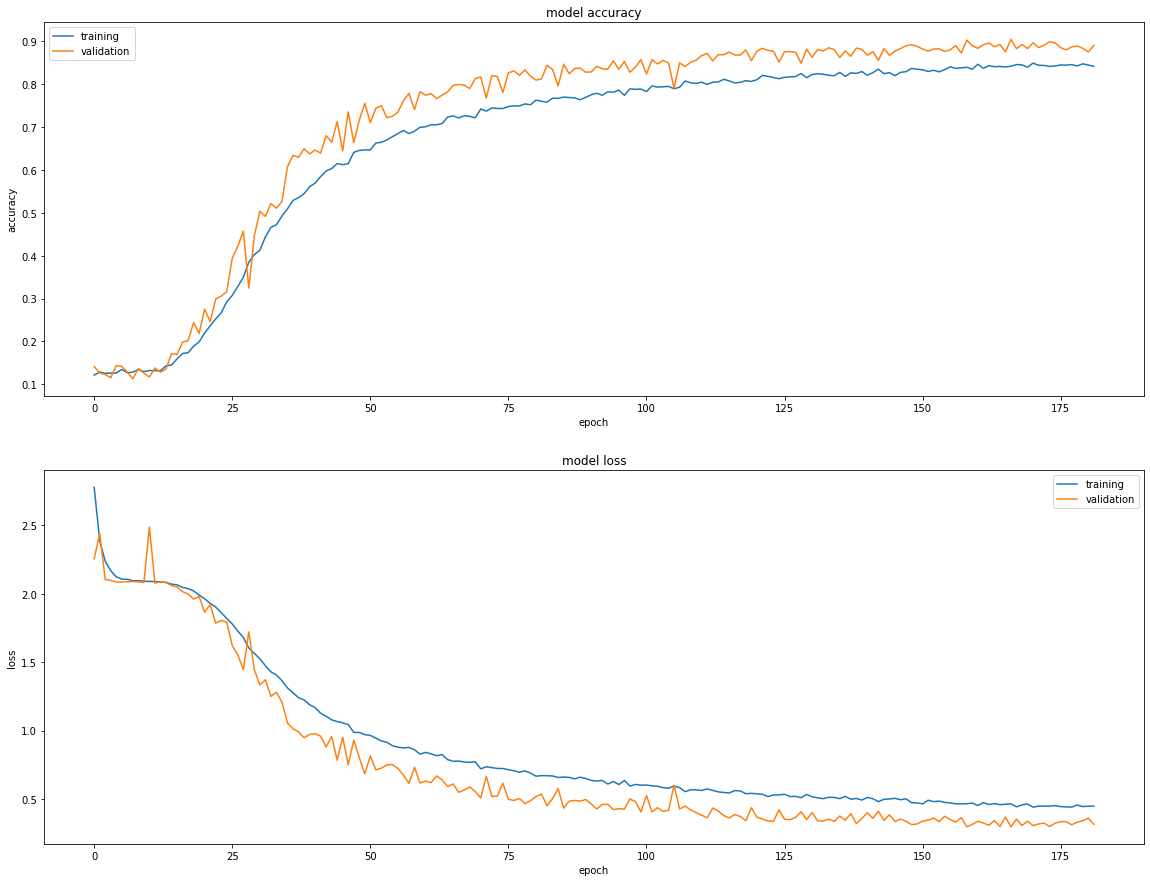

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_top.history['accuracy'], history_top.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_top.history['loss'], history_top.history['val_loss'], 'loss', 212)

In [ ]:
y_pred = model_top.predict(X_test)
y_test_2, y_pred = np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=1) #magical fix

print(metrics.classification_report(y_test_2, y_pred, digits=3))
accuracy_cnn = metrics.accuracy_score(y_test_2, y_pred)
f1_cnn = metrics.f1_score(y_test_2, y_pred, average='weighted')
precision_cnn = metrics.precision_score(y_test_2, y_pred, average='weighted')
recall_cnn = metrics.recall_score(y_test_2, y_pred, average='weighted')
print("Accuracy", accuracy_cnn * 100)

35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0      0.924     0.930     0.927       143
           1      0.934     0.904     0.919       157
           2      0.803     0.866     0.833       127
           3      0.918     0.918     0.918       134
           4      0.935     0.935     0.935       139
           5      0.959     0.939     0.949       148
           6      0.899     0.937     0.917       142
           7      0.876     0.815     0.845       130

    accuracy                          0.907      1120
   macro avg      0.906     0.906     0.905      1120
weighted avg      0.908     0.907     0.907      1120

Accuracy 90.71428571428571


In [ ]:
y_p = model_top.predict(X_test)
y_p_labels = np.argmax(y_p, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), y_p_labels)
pce = np.diag(cm) / np.sum(cm, axis=1)
print(pce)

overall_pce = np.mean(pce)

# Print the PCE for each class and the overall PCE score
print('Per-class PCE:', pce)
print('Overall PCE:', overall_pce)
print('Middle 6 PCE:', np.mean(pce[1:7]))

35/35 [==============================] - 0s 2ms/step
[0.93006993 0.9044586  0.86614173 0.91791045 0.9352518  0.93918919
 0.93661972 0.81538462]
Per-class PCE: [0.93006993 0.9044586  0.86614173 0.91791045 0.9352518  0.93918919
 0.93661972 0.81538462]
Overall PCE: 0.9056282537856898
Middle 6 PCE: 0.9165952474718287


In [ ]:
class_names

['Impact',
 'Mid-Follow-Through',
 'Mid-Backswing',
 'Top',
 'Address',
 'Finish',
 'Toe-up',
 'Mid-Downswing']

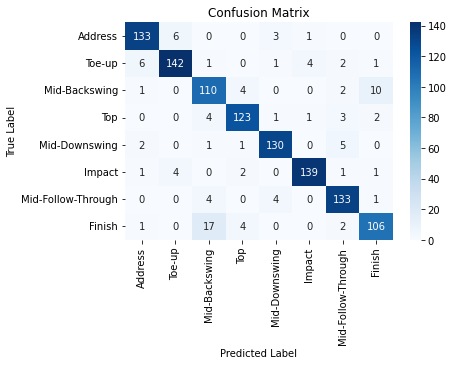

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['Address', 'Toe-up', 'Mid-Backswing', 'Top', 'Mid-Downswing', 'Impact', 'Mid-Follow-Through', 'Finish']
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()